In [78]:
import keras
from keras.preprocessing.sequence import pad_sequences
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.utils import plot_model, vis_utils
from IPython.display import SVG
from  sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import TSNE
import numpy as np

In [2]:
imdb = keras.datasets.imdb

In [64]:
VOCAB_SIZE = 10000
INDEX_FROM = 2
(train_data,train_labels),(test_data,test_labels) = imdb.load_data(num_words=VOCAB_SIZE,
index_from=INDEX_FROM)
print('Sample review:', train_data[0])
print('\n Sample label:', test_labels[1])

Sample review: [1, 13, 21, 15, 42, 529, 972, 1621, 1384, 64, 457, 4467, 65, 3940, 3, 172, 35, 255, 4, 24, 99, 42, 837, 111, 49, 669, 2, 8, 34, 479, 283, 4, 149, 3, 171, 111, 166, 2, 335, 384, 38, 3, 171, 4535, 1110, 16, 545, 37, 12, 446, 3, 191, 49, 15, 5, 146, 2024, 18, 13, 21, 3, 1919, 4612, 468, 3, 21, 70, 86, 11, 15, 42, 529, 37, 75, 14, 12, 1246, 3, 21, 16, 514, 16, 11, 15, 625, 17, 2, 4, 61, 385, 11, 7, 315, 7, 105, 4, 3, 2222, 5243, 15, 479, 65, 3784, 32, 3, 129, 11, 15, 37, 618, 4, 24, 123, 50, 35, 134, 47, 24, 1414, 32, 5, 21, 11, 214, 27, 76, 51, 4, 13, 406, 15, 81, 2, 7, 3, 106, 116, 5951, 14, 255, 3, 2, 6, 3765, 4, 722, 35, 70, 42, 529, 475, 25, 399, 316, 45, 6, 3, 2, 1028, 12, 103, 87, 3, 380, 14, 296, 97, 31, 2070, 55, 25, 140, 5, 193, 7485, 17, 3, 225, 21, 20, 133, 475, 25, 479, 4, 143, 29, 5534, 17, 50, 35, 27, 223, 91, 24, 103, 3, 225, 64, 15, 37, 1333, 87, 11, 15, 282, 4, 15, 4471, 112, 102, 31, 14, 15, 5344, 18, 177, 31]

 Sample label: 1


In [65]:
MAXIMUM_LENGTH = 500
print('Length of sample train_data before preprocessing:', len(train_data[0]))

preprocessed_train_data = pad_sequences(train_data, MAXIMUM_LENGTH)
print('Length of sample train_data after preprocessing:', len(preprocessed_train_data[0]))
unpreprocessed_train_data = train_data
train_data = preprocessed_train_data

Length of sample train_data before preprocessing: 218
Length of sample train_data after preprocessing: 500


In [15]:
EMBED_SIZE = 100
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE,input_length=MAXIMUM_LENGTH))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 100)          1000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 1,080,501
Trainable params: 1,080,501
Non-trainable params: 0
_________________________________________________________________


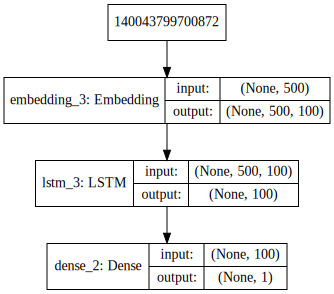

In [17]:
SVG(vis_utils.model_to_dot(
model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [40]:
# Stratified count done to avoid class imbalance. 2000 val instances
x_train, x_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=2000, stratify=train_labels)
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, train_data.shape)

(23000, 500) (23000,) (2000, 500) (2000,) (25000, 500)


In [41]:
history = model.fit(x_train,y_train,epochs=3,batch_size=128,validation_data=(x_val, y_val),verbose=1)

Train on 23000 samples, validate on 2000 samples
Epoch 1/3
23000/23000 [==============================] - 178s 8ms/step - loss: 0.4974 - acc: 0.7482 - val_loss: 0.3334 - val_acc: 0.8625
Epoch 2/3
23000/23000 [==============================] - 171s 7ms/step - loss: 0.2682 - acc: 0.8940 - val_loss: 0.2910 - val_acc: 0.8780
Epoch 3/3
23000/23000 [==============================] - 171s 7ms/step - loss: 0.1879 - acc: 0.9313 - val_loss: 0.3290 - val_acc: 0.8835


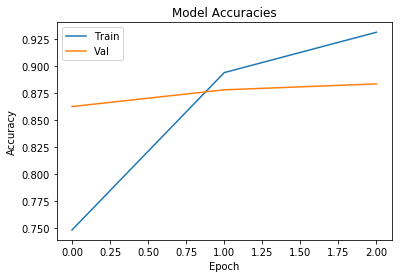

In [45]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'])
plt.show()
# The graph actually shows validation still slowly increasing with epochs 
# so we should probabaly keep training the model. 
# Although it looks like it's slowing down so unlikely to benefit from more than a small number more

In [47]:
test_data = pad_sequences(test_data, MAXIMUM_LENGTH)
results = model.evaluate(test_data, test_labels)

25000/25000 [==============================] - 230s 9ms/step


In [48]:
print('test_loss:', results[0], 'test_accuracy:', results[1])

test_loss: 0.3570875749349594 test_accuracy: 0.87012


In [51]:
word_embeddings = model.get_layer('embedding_3').get_weights()[0]
print('Shape of word_embeddings:', word_embeddings.shape)

Shape of word_embeddings: (10000, 100)


In [73]:
word2idx = imdb.get_word_index()
word2idx = {k:(v+INDEX_FROM) for k,v in word2idx.items() if v < 9998}
word2idx["<PAD>"] = 0
word2idx["<START>"] = 1
word2idx["<UNK>"] = 2

In [80]:
idx2word = {}
for key in word2idx.keys():
    idx2word[word2idx[key]] = key
#print(' '.join(idx2word[idx] for idx in train_data[0]))
#print(train_data[0])

In [81]:
#print(pd.DataFrame(word_embeddings, index=idx2word.values()).head(10))

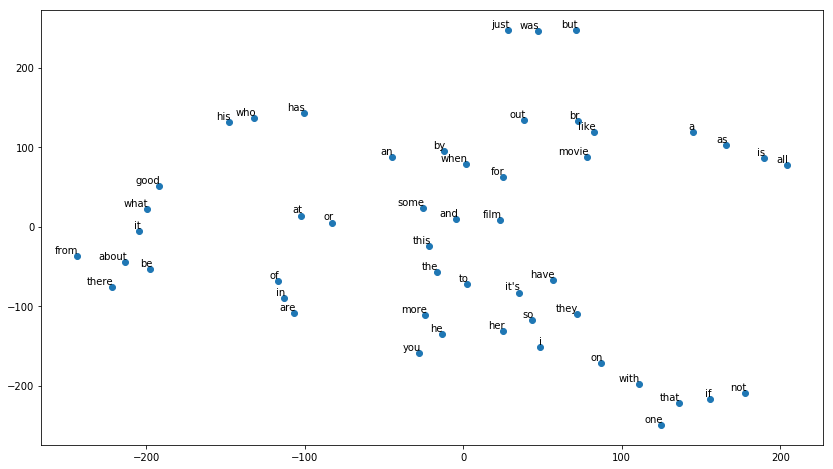

In [82]:
tsne = TSNE(perplexity=3, n_components=2, init='pca', n_iter=5000, method='exact')
np.set_printoptions(suppress=True)
start = 3
plot_only = 54
T = tsne.fit_transform(word_embeddings[start:plot_only, :])
labels = [idx2word[i] for i in range(start, plot_only)]
plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1])
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points',ha='right',va='bottom')